# Outline of project

* Dataset being imported
* Visualize some aspect of the dataset
* Create Train and Validation dataset
* Create Our Vocabulary and tokenizer
* Create the Model
* setup the training loop for the model
* Visualizatoin of model prediction

Metrics Blue, Earlystoping as per paper,  


## Imports

In [111]:
import numpy as np
import os, random
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from tqdm import tqdm
import torchsummary
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu

## Data Visualization

As per dataset decription, each image has 5 captions avaialable let's see a few of them and how they look like

In [2]:
def load_dataset_dict(caption_path):
    df = pd.read_csv(caption_path)
    caption_dict = defaultdict(list)
    for _, row in df.iterrows():
        caption_dict[row.image].append(row.caption)
    return caption_dict

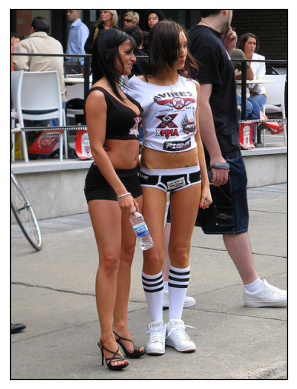

Two girls wait on the street while wearing tight , barely there clothing .
Two ladies stand on a sidewalk wearing skimpy clothes and men 's underwear .
Two scantily-clad women on a city sidewalk .
Two women in skimpy outfits are posing to have their picture taken .
Two young women in tight clothing .


In [3]:
image_id, captions = random.choice(list(load_dataset_dict("data/captions.txt").items()))
data_dir = "data/images"
full_image_path = os.path.join(data_dir, image_id)
image = Image.open(full_image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()
for caption in captions:
    print(caption)


## EDA

In [4]:
df = pd.read_csv("data/captions.txt")
df_captions = df.caption

In [51]:
def count_words(df):
    vocabulary = []
    for txt in df.caption.values:
        vocabulary.extend(txt.split())
    counter = defaultdict(int)

    for word in vocabulary:
        counter[word.lower()] += 1
    sorted_items = sorted(counter.items(), key=lambda item: item[-1], reverse=True)


    df = pd.DataFrame(sorted_items, columns=['word', 'count'])

    return df

df_counter = count_words(df)

In [53]:
df_counter.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


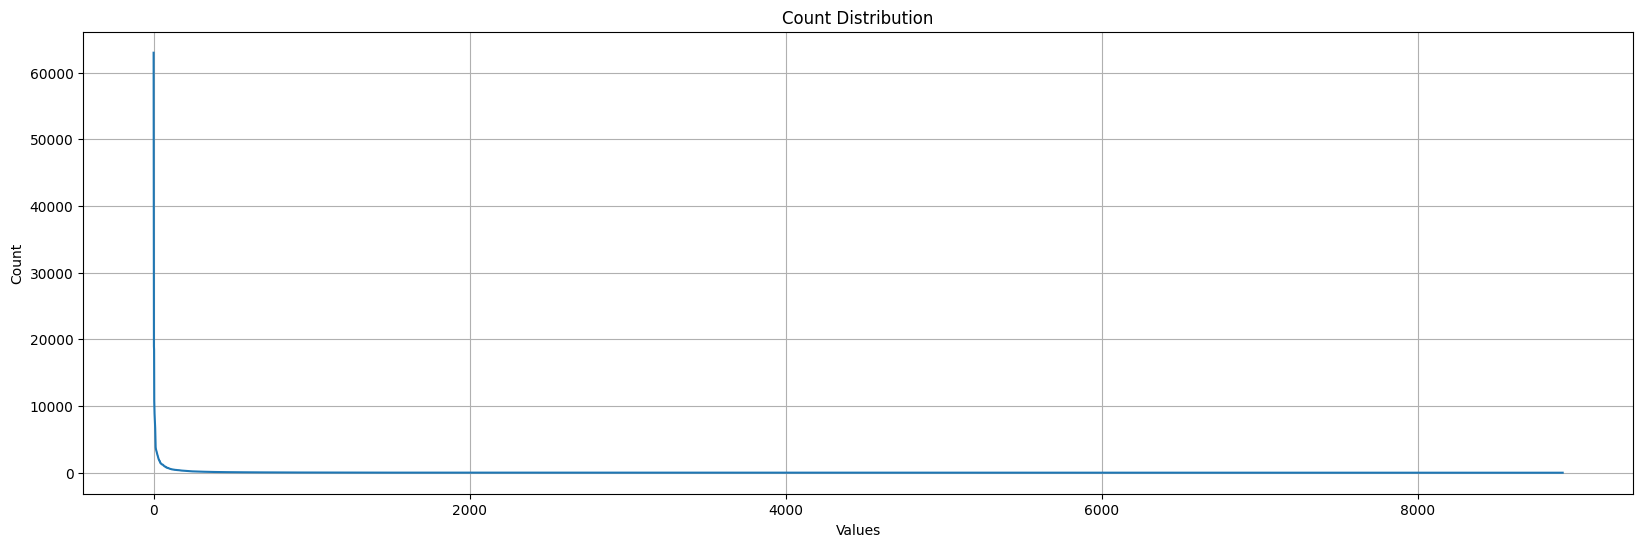

In [57]:
df_counter["count"].plot(grid=True, figsize=(20, 6))
plt.title("Count Distribution")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'plot of count vs words')

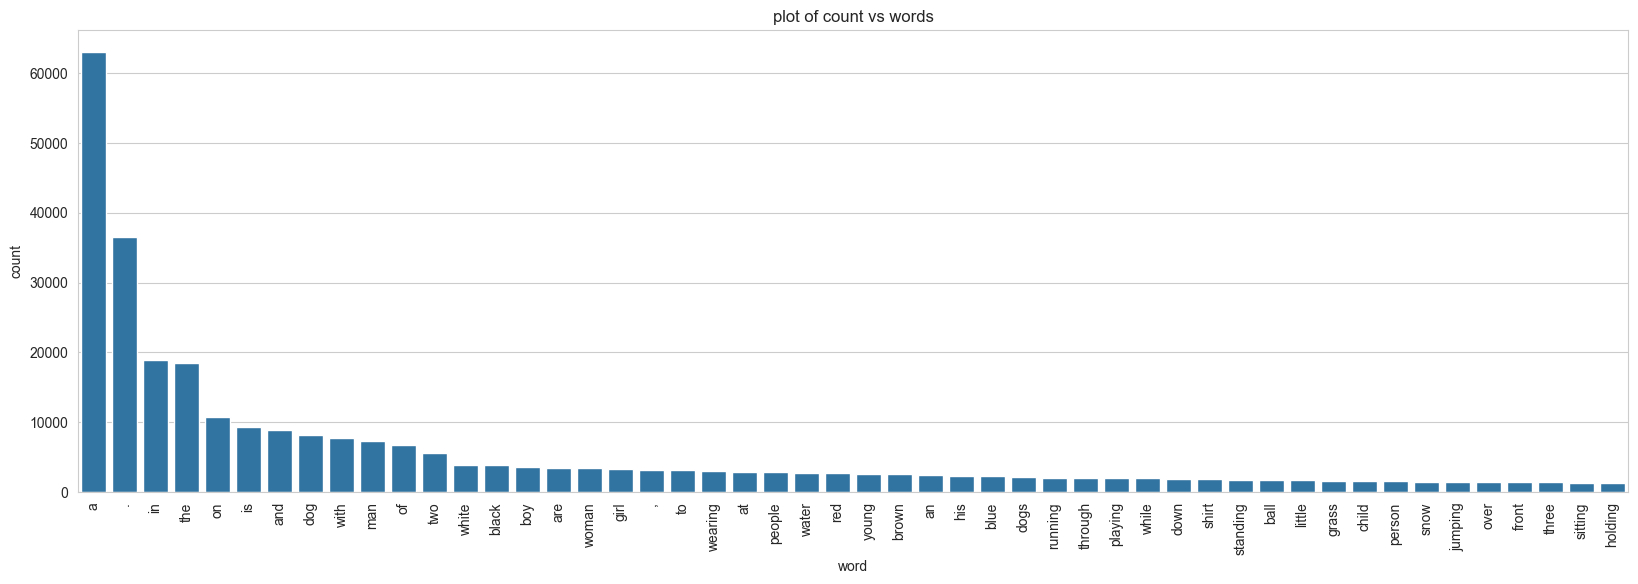

In [69]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_counter[:50], y='count', x="word")
plt.xticks(rotation="vertical")
plt.title("plot of count vs words")

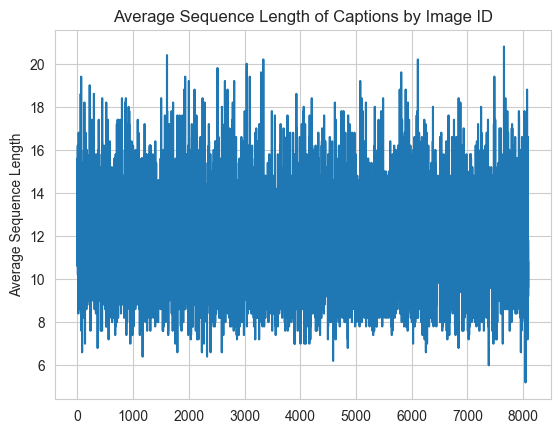

In [77]:
df['sequence_length'] = df['caption'].apply(lambda x: len(x.split()))

# Step 3: Group by 'image_id' and calculate the average sequence length
avg_sequence_length = df.groupby('image')['sequence_length'].mean().reset_index()
avg_sequence_length['sequence_length'].plot()
plt.ylabel('Average Sequence Length')
plt.title('Average Sequence Length of Captions by Image ID')
plt.show()

## Train, Val Split

In [4]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [5]:
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [6]:
for i in train_data.values():
    for j in i:
        print(j)
    break

A lean dog races along a dirt track .
A racing dog takes flight while wearing a yellow and black jersey , and muzzle
A white greyhound wearing a yellow and black jacket is running on a track .
A white race dog wearing the number eight runs on the track .
A white racing dog wearing the number 8 is midstride running down a track .


In [7]:
hash_map = {"a"}
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map.add(word.lower())
len(hash_map)


8080

In [8]:
hash_map_val = {"a"}
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map_val.add(word.lower())
len(hash_map_val)

8080

In [9]:
hash_map.difference(hash_map_val)

set()

In [10]:
hash_map_val.difference(hash_map)

set()

*Note*: all the words in train are also in out test data

## Vocabulary and tokenizer

In [ ]:
!python -m spacy download en_core_web_sm

In [12]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    
    def vocabulary_size(self):
        return len(self.stoi) - 4

In [13]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8504

In [14]:
vocabulary.tokenize("creates a human whose, name is not Tom James")

[5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]

In [15]:
vocabulary.stoi["<PAD>"]

0

In [141]:
class FlickrDataset(Dataset):

    def __init__(self, image_dir, vocabulary: Vocabulary, data_dict, transform=None, train=True):
        self.data_dict = data_dict
        self.transform = transform
        self.image_dir = image_dir


        self.train = train
        self.item = self.setup_item()
        
        self.vocabulary = vocabulary

    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                item.append((image_id, image_captions))
        return item

    def __len__(self):
        return len(self.item)


    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        caption = self.item[index][1]
        if self.train:
            num_caption = [self.vocabulary.stoi['<SOS>']]
            num_caption += self.vocabulary.tokenize(caption)
            num_caption.append(self.vocabulary.stoi['<EOS>'])
            num_caption = torch.tensor(num_caption)
            return img, num_caption
        else:
            captions = []
            for cap in caption:
                num_caption = [self.vocabulary.stoi['<SOS>']]
                num_caption += self.vocabulary.tokenize(cap)
                num_caption.append(self.vocabulary.stoi['<EOS>'])
                captions.append(torch.tensor(num_caption))
            return img, pad_sequence(captions, batch_first=False, padding_value=0)
        

In [187]:
class MyCollate:
    def __init__(self, pad_idx, train=True):
        self.pad_idx = pad_idx
        self.train = train
    
    def __call__(self, batch): # pad sequnece
        img = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(img, 0)
        target = [item[1] for item in batch]
        if self.train:
            target = pad_sequence(target, batch_first=True, padding_value=self.pad_idx)
        else:
            #for i in target:
            #    print(i.shape)
            target = pad_sequence(target, batch_first=True, padding_value=self.pad_idx)
            target=target.permute(0, 2, 1).contiguous() #get back to regular batch_first = True

        return img, target

In [188]:
def get_loader(
        image_folder,
        data_dict,
        vocabulary,
        transform,
        train=True,
        batch_size=32,
        num_worker=0,
        shuffle=True,
        pin_memory=True
):
    dataset = FlickrDataset(image_dir=image_folder, vocabulary=vocabulary, data_dict=data_dict,
                            transform=transform, train=train)
    pad_idx = vocabulary.stoi["<PAD>"]
    
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=MyCollate(pad_idx=pad_idx, train=train),
        pin_memory=pin_memory,
        shuffle=shuffle,
        num_workers=num_worker,
    )

    return loader, dataset

In [170]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8504

In [171]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [172]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [173]:
train_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=train_data,
                        transform=transform, train=True)

In [174]:
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([21])


In [189]:
val_dataset = FlickrDataset(image_dir=folder, vocabulary=vocabulary, data_dict=val_data,
                        transform=transform, train=False)

In [190]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", len(random_label), random_label.shape)
## using list of sequence with training = False (not tensor and pad)

Random Shape: torch.Size([3, 224, 224])
Random Caption: 18 torch.Size([18, 5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 5, 26])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 26])
['<SOS>', 'a', 'car', 'splashes', 'through', 'mud', 'and', 'leaves', 'on', 'the', 'forest', 'floor', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'four', 'wheel', 'drive', 'car', 'is', 'splashing', 'through', 'puddles', 'on', 'an', 'off', 'road', 'trail', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'large', 'van', 'drives', 'down', 'a', 'counry', 'road', 'in', 'the', 'fall', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'large', 'suv', 'driving', 'through', 'a', 'large', 'puddle', 'in', 'the', 'forest', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'suv',

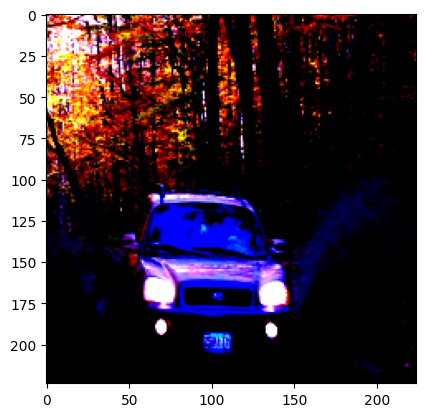

In [192]:
val_loader, _ = get_loader(image_folder=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)

for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    first_image = image[1]
    print(first_image.shape)
    first_caption = caption[1]
    print(first_caption.shape)
    plt.imshow(first_image.permute(1,2,0))
    for i in range(len(first_caption)):
        caption = [vocabulary.itos[element] for element in first_caption[i].tolist()]
        print(caption)
    break

## Model

### Encoder

In [26]:
model = vgg19("VGG19_Weights.IMAGENET1K_V1")

/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


#### Test

In [172]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [173]:
list(model.features.children())[:-1]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [162]:
# Path to your image file
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)

modules = list(model.features.children())[:-1]
test_model = nn.Sequential(*modules)

output = test_model(image_tensor)
print(output.shape)
print(image_tensor.shape)

torch.Size([1, 512, 14, 14])
torch.Size([1, 3, 224, 224])


#### Model

In [27]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        model = vgg19("VGG19_Weights.IMAGENET1K_V1")
        self.model = list(model.features.children())[:-1]
        self.model = nn.Sequential(*self.model)
        self.dim = 512
    
    def forward(self, images):
        out = self.model(images)
        out = out.permute(0, 2, 3, 1)
        out = out.view(out.size(0), -1, out.size(-1))
        return out



### Test

In [29]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)

# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), 64)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(512, 256)
init_c = nn.Linear(512, 256)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(512, 128)
decorder_attention = nn.Linear(256, 128)
attend = nn.Linear(128, 1)

# Decoder
lstm = nn.LSTMCell(512+64, 256)
fc = nn.Linear(256, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att)
        print("alpha shape:", alpha.shape)
        weighted_context = (output * alpha.unsqueeze(2))
        print("unsqueze weight context shape:", weighted_context.shape)
        weighted_context = weighted_context.sum(dim=1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print(lstm_input.shape)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 



/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


encoded image shape:  torch.Size([1, 196, 512])
tokenize caption shape: torch.Size([1, 20])
embedded caption shape: torch.Size([1, 20, 64])
shape of average encoder output: torch.Size([1, 512])
shape of initial h: torch.Size([1, 256])
shape of inital c: torch.Size([1, 256])
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled attention score shape: {torch.Size([1, 196])}
alpha shape: torch.Size([1, 196])
unsqueze weight context shape: torch.Size([1, 196, 512])
full weighted context shape: {torch.Size([1, 512])}
--------- DONE CALCULATING ATTENTION SCORE -----------
torch.Size([1, 64])
torch.Size([1, 576])
word_proabability shape: torch.Size([1, 8504])
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled

### Attention

In [31]:
class Attention(nn.Module):
    """
    Attention Network. Using Additive or BahdanauAttention
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_attention = nn.Linear(encoder_dim, attention_dim)
        self.decorder_attention = nn.Linear(decoder_dim, attention_dim)
        self.attend = nn.Linear(attention_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, hidden_state):
        img_matrix = self.encoder_attention(encoder_out)
        hidden_matrix = self.decorder_attention(hidden_state).unsqueeze(1)
        add = self.tanh(img_matrix + hidden_matrix)
        att = self.attend(add).squeeze(2)
        alpha = self.softmax(att)
        weighted_context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return weighted_context, alpha


    

In [72]:
class Decoder(nn.Module):
    
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):

        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout()

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.output = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out: torch.Tensor):
        average_out = encoder_out.mean(dim=1)
        h = self.init_h(average_out)
        c = self.init_c(average_out)
        return h, c
    

    def forward(self, encoder_out, caption):

        embeddings = self.embedding(caption)

        h, c = self.init_hidden_state(encoder_out)

        predictions = torch.zeros(caption.shape[0], caption.shape[1], self.vocab_size)
        alphas = torch.zeros(caption.shape[0], caption.shape[1], encoder_out.shape[1])

        for i in range(caption.shape[1]):
            weighted_context, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))
            weighted_context = gate * weighted_context
            lstm_input = torch.cat([embeddings[:,i,:], weighted_context], dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            word_prop = self.output(self.dropout(h))
            predictions[:,i,:] = word_prop
            alphas[:,i,:] = alpha
        
        return predictions, alphas







### test decoder

In [73]:
mage_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()


# caption
caption = "A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel ."
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)


output = enocder(image_tensor)
decoder = Decoder(512, 256, 512, 256, vocabulary.vocabulary_size())
preds, als = decoder(output, caption)

### Caption

In [51]:
class Caption(nn.Module):
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size):
        super(Caption, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(embed_dim=embed_dim, attention_dim=attention_dim,
                               encoder_dim=encoder_dim, decoder_dim=decoder_dim, vocab_size=vocab_size)
    
    def forward(self, img, captions):
        features = self.encoder(img)
        predictions, alphas = self.decoder(features, captions)
        return predictions, alphas

    def caption_img(self, img, vocab, max_length=100):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img) 
            h, c = self.decoder.init_hidden_state(feature)

            ## first input to the model
            start = torch.zeros(size=(1,), dtype=torch.int)
            start[0] = vocabulary.stoi['<SOS>']
            start = start.unsqueeze(0)
            embeddings = self.decoder.embedding(start).squeeze(0)
            ##print(embeddings.shape)

            for _ in range(max_length):
                weighted_context, alpha = self.decoder.attention(feature, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context
                #print(weighted_context.shape)
                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                #print(lstm_input.shape)

                h, c = self.decoder.lstm(lstm_input, (h, c))
                #print(h.shape)
                output = self.decoder.output(h.squeeze(0)) # removing the extra dimension needed in lstm
                #print(output.shape)
                predicted = output.argmax(0) # highest probablities word
                result_caption.append(predicted.item())
                embeddings = self.decoder.embedding(predicted).unsqueeze(0)
                #print(embeddings.shape)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence

    def beam_search(self, img, k, vocab=vocabulary):
        with torch.no_grad():
            encoder_out = self.encoder(img) # (1, num_pixels, encoder_dim)
            num_pixels = encoder_out.size(1)

            encoder_dim = encoder_out.size(-1)



            # we'll treat the problem as having a batch size of k
            encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)    # (k, num_pixels, encoder_dim)

            # tensor to store top k previous words at each step; now they're just <SOS> token
            top_k_prev_words = torch.tensor([[vocabulary.stoi['<SOS>']]] * k, dtype=torch.long)  # (k, 1)

            # tensor to store top k sequences for the entire algorithm; now they're just <start>
            top_k_seqs = top_k_prev_words

            # tensor to store top k sequences' scores; now they're just 0
            top_k_scores = torch.zeros(k, 1)

            # tensor to store top k sequences' alphas; now they're just 1s
            top_k_seqs_alpha = torch.ones(k, 1, num_pixels) #(k, 1, enc_image_size)

            # lists to store completed sequences along with their alphas and scores
            complete_seqs = []
            complete_seqs_alpha = []
            complete_seqs_scores = []

            ## Actual decoding step
            step = 1
            h, c = self.decoder.init_hidden_state(encoder_out) 

            # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
            while True:
                embeddings = self.decoder.embedding(top_k_prev_words).squeeze(1) # (s, embed_dim)
                weighted_context, alpha = self.decoder.attention(encoder_out, h)
                gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                weighted_context = gate * weighted_context

                lstm_input = torch.cat([embeddings, weighted_context], dim=1)
                h, c = self.decoder.lstm(lstm_input, (h, c)) # (s, decoder_dim)

                scores = self.decoder.output(h)      # (s, vocab_size)
                scores = F.log_softmax(scores, dim=1)

                #
                scores = top_k_scores.expand_as(scores) + scores    # (s, vocab_size)
                # all the k points will have the same score for the first step (since same k previous words, h, c)
                if step == 1:
                    top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)    # (s)
                else:
                    # unroll and find top scores, and their unrolled indices
                    top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)    # (s)
                
                # convert unrolled indices to actual indices of scores
                prev_word_idx = top_k_words // len(vocab)
                next_word_idx = top_k_words % len(vocab)

                # add new words to sequences, alphas
                top_k_seqs = torch.cat([top_k_seqs[prev_word_idx], next_word_idx.unsqueeze(1)], dim=1) # (s, step + 1)
                top_k_seqs_alpha = torch.cat([top_k_seqs_alpha[prev_word_idx], alpha[prev_word_idx].unsqueeze(1)], dim = 1)

                # which sequences are incomplete (didn't reach <EOS>)?
                incomplete_idx = [idx for idx, next_word in enumerate(next_word_idx)
                                  if next_word != vocab.stoi['EOS']]
                complete_idx = list(set(range(len(next_word_idx))) - set(incomplete_idx))

                # set aside complete sequences
                if len(complete_idx)>0:
                    complete_seqs.extend(top_k_seqs[complete_idx].to_list())
                    complete_seqs_alpha.extend(top_k_seqs_alpha[complete_idx].to_list())
                    complete_seqs_scores.extend(top_k_scores[complete_idx].to_list())
                k -= len(complete_idx)

                # update the remaning values to only deal with incomplete sentences
                top_k_seqs = top_k_seqs[incomplete_idx]
                top_k_seqs_alpha = top_k_seqs_alpha[incomplete_idx]
                top_k_scores = top_k_scores[incomplete_idx].unsqueeze(1)
                top_k_prev_words = next_word_idx[incomplete_idx].unsqueeze(1)

                encoder_out = encoder_out[prev_word_idx[incomplete_idx]]
                h= h[prev_word_idx[incomplete_idx]]
                c = c[prev_word_idx[incomplete_idx]]

                if step > 50:
                    break
                step += 1



In [36]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
captioner = Caption(embed_dim=256,
                    attention_dim=128,
                    encoder_dim=512,
                    decoder_dim=64,
                    vocab_size=len(vocabulary))

In [37]:
features = captioner.encoder(image_tensor)
features.shape

torch.Size([1, 196, 512])

In [38]:
encoder_out = features.expand(3, features.size(1), features.size(-1))
(encoder_out[2,:,:] != features).sum()

tensor(0)

## Training Loop

In [77]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [78]:
def train_epoch(train_loader, captioner: Caption, device, criterion, optimizer, alpha_c, epoch):
    losses = []
    top5acc = []

    captioner.train()

    for idx, (imgs, caps) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        # forward prop
        predictions, alphas = captioner(imgs, caps)

        
        att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
        loss = criterion(predictions, caps) + att_regularization

        loss.backward()
        optimizer.step()

        # keep track of metrics
        top5 = accuracy(predictions, caps, 5)
        losses.append(loss.item())
        top5acc.append(top5)

    print('Epoch #: [{0}]\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            'Top 5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(
                epoch, len(train_loader), loss=losses, top5=top5))

    return np.mean(losses), np.mean(top5acc)



    

In [ ]:
def val_epoch(val_data, captioner, criterion, device, optimizer, alpha_c):
    captioner.eval()
    losses = []
    top5acc = []
    with torch.no_grad:
        for idx, (images, captions) in val_data:
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # forward prop
            predictions, alphas = captioner(images, captions)

            att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
            loss = criterion(predictions, caption) + att_regularization


            # keep track of metrics
            top5 = accuracy(predictions, captions, 5)
            losses.append(loss.item())
            top5acc.append(top5)
            
            
                

            


        
    pass

In [ ]:
# model parameters



In [76]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

print(f"Currently using the {device} device")
train_loader, dataset = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
captioner = Caption(512, 512, 512, 512, len(vocabulary))
captioner.to(device)
captioner.train()
for idx, (images, captions) in enumerate(train_loader):
    images= images.to(device)
    captions = captions.to(device)
    predictions, alpha = captioner(images, captions)
    print(f"Shape of the cations batch: {captions.shape}")
    print(f"Shape of the prediction batch:{predictions.shape}")
    print(f"shape of the alpha batch: {alpha.shape}")
    print(f"done with idx: {idx}")
    break


Currently using the mps device


/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Shape of the cations batch: torch.Size([32, 24])
Shape of the prediction batch:torch.Size([32, 24, 8508])
shape of the alpha batch: torch.Size([32, 24, 196])
done with idx: 0
